# Content

- Evaluation des performances des modèles d’apprentissage supervisé selon différents critères (scores, temps d'entraînement, etc.) en adaptant les paramètres afin de choisir le modèle le plus performant pour la problématique métier.
- Calcul un score avec fp + 10 * fn

precision, recall, accuracy, roc_auc, f1
        fbeta_macro
        fbeta_micro
        fbeta_weighted
        
hyperparameter search for the following methods: XGBoost, LightGBM, Random Forest. Save each model, best parameters and evaluation metrics with MLflow. Save the evaluation metrics for all models to a dataframe.

- [ 0 - Library definition](#0) 
- [ 1 - Data definition](#1) 
- [ 1.1 - Imbalanced Data Definition](#1.1) 
- [ 2 - Metrics definition](#2) 
- [ 3 - Model definition](#3) 
- [ 4 - Run 1 EXPERIMENT with 6 RUNs](#4)
- [ 5 - Model Evaluation](#(5)
- [ 6 - Feature Importance](#(6)
- [ 7 - Feature Selection after SHAP feature Importance](#(7)

<a name='0'></a>
# 0 Library definition

In [258]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
import time

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import auc
from sklearn.metrics import fbeta_score

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import mlflow
import mlflow.sklearn
from mlflow import MlflowClient
from mlflow.models.signature import infer_signature

from prettytable import PrettyTable

from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from numpy import where
import shap

<a name='1'></a>
# 1 Data definition

In [3]:
X_train = pd.read_csv('../2_INPUT_DATA/3_SPLIT/X_train.csv')
Y_train = pd.read_csv('../2_INPUT_DATA/3_SPLIT/Y_train.csv')
X_test = pd.read_csv('../2_INPUT_DATA/3_SPLIT/X_test.csv')
Y_test = pd.read_csv('../2_INPUT_DATA/3_SPLIT/Y_test.csv')
ids_test = pd.read_csv('../2_INPUT_DATA/3_SPLIT/ids_test.csv')
feature_names = pd.read_csv('../2_INPUT_DATA/2_FEATURE_PROCESSED/feature_names.csv')

print("X_train", X_train.shape)
print("Y_train", Y_train.shape)
print("Y_test", Y_test.shape)
print("ids_test",ids_test.shape)
print("feature names", feature_names.shape)

X_train (246008, 239)
Y_train (246008, 1)
Y_test (61503, 1)
ids_test (246008, 1)
feature names (239, 1)


In [255]:
def scale_data(df_train, df_test):
    """
    Scale the features in the training and testing datasets using Min-Max scaling.

    Args:
    df_train (DataFrame): The training dataset to be scaled.
    df_test (DataFrame): The testing dataset to be scaled.

    Returns:
    df_train_scaled (DataFrame): The scaled training dataset.
    df_test_scaled (DataFrame): The scaled testing dataset.
    """
    # Initialize MinMaxScaler with feature range between 0 and 1
    scaler = MinMaxScaler(feature_range=(0, 1))

    # Fit and transform the training dataset
    df_train_scaled = scaler.fit_transform(df_train)

    # Transform the testing dataset using the same scaler fitted on the training data
    df_test_scaled = scaler.transform(df_test)

    return df_train_scaled, df_test_scaled

In [ ]:
#test = X_train.copy()
#test["ID"] = ids_test
#test.set_index("ID", inplace=True)
#ids_test.iloc[5]
#test.loc[100008].values.tolist()

<a name='1.1'></a>
# 1.1 Imbalanced Data treatment

In [4]:

def SMOTE_transformation(X, y):
    # summarize class distribution
    counter = Counter(y)
    print(counter)
    # define pipeline
    over = SMOTE(sampling_strategy=0.1)
    under = RandomUnderSampler(sampling_strategy=0.5)
    steps = [('o', over), ('u', under)]
    pipeline = Pipeline(steps=steps)
    # transform the dataset
    X, y = pipeline.fit_resample(X, y)
    # summarize the new class distribution
    counter = Counter(y)
    print(counter)
    # scatter plot of examples by class label
    #for label, _ in counter.items():
    #    print(label)
    #    row_ix = where(y == label)[0]
    #    print(row_ix)
    #    pyplot.scatter(X[row_ix, 0], X[row_ix, 1], label=str(label))
        
    #pyplot.legend()
    #pyplot.show()
    
    return X, y

x_train_smote, y_train_smote = SMOTE_transformation(X_train, Y_train['TARGET'])

Counter({0: 226067, 1: 19941})
Counter({0: 45212, 1: 22606})


<a name='2'></a>
# 2 Metrics definition

**Fbeta Score**

![alt text for screen readers](IMAGES/fbetascore.png "Fbeta Score")

A smaller beta value, such as 0.5, gives more weight to precision and less to recall, whereas a larger beta value, such as 2.0, gives less weight to precision and more weight to recall in the calculation of the score.

#### FN et FP  
On simule la supposition, que le coût d’un FN est dix fois supérieur au coût d’un FP.  
On crée un score “métier” en minimisant le coût d’erreur de prédiction des FN et FP pour comparer les modèles, afin de choisir le meilleur modèle et ses meilleurs hyperparamètres.

**Precision**  
(tp / (tp + fp))
It describes how good a model is at predicting the positive class. Precision is referred to as the positive predictive value.  

**Recall** is the same as sensitivity.
(tp / (tp + fn)    
Recall describes how good the model is at predicting the positive class when the actual outcome is positive.


We want to optimize recall.

In [125]:
def fbeta_score_calculation(y_true, y_pred):
    fbeta_macro = fbeta_score(y_true, y_pred, average='macro', beta=2)
    fbeta_micro = fbeta_score(y_true, y_pred, average='micro', beta=2)
    fbeta_weighted = fbeta_score(y_true, y_pred, average='weighted', beta=2)
    return round(fbeta_macro,2), round(fbeta_micro,2), round(fbeta_weighted,2)

def plot_roc_curve(true_y, y_prob):
    """
    plots the roc curve based of the probabilities
    """

    fpr, tpr, thresholds = roc_curve(true_y, y_prob)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
def reminder_TP(TN="", FP="", FN="", TP=""):
    #tn, fp, fn, tp
    # Create a PrettyTable instance
    table = PrettyTable()

    # Define columns and headers
    table.field_names = ['Confusion Matrix', 'Positive prediction', 'Negative prediction']

    # Add rows
    table.add_row(['Positive class', 'True positive (TP)', 'False negative (FN)'])
    table.add_row(['Negative class', 'False positive (FP)', 'True negative (TN)'])

    # Print the table
    print(table)
    
    if TN :
        # Create a PrettyTable instance
        table2 = PrettyTable()

        # Define columns and headers
        table2.field_names = ['Confusion Matrix', 'Positive prediction', 'Negative prediction']

        # Add rows
        table2.add_row(['Positive class', TP, FN])
        table2.add_row(['Negative class', FP, TN])

        # Print the table
        print(table2)
    

def generate_recall_precision_curve(model, X_test, Y_test):
    # predict probabilities
    lr_probs = model.predict_proba(X_test)
    # keep probabilities for the positive outcome only
    lr_probs = lr_probs[:, 1]
    # predict class values
    yhat = model.predict(X_test)
    lr_precision, lr_recall, _ = precision_recall_curve(Y_test, lr_probs)
    lr_f1, lr_auc = f1_score(Y_test, yhat), auc(lr_recall, lr_precision)
    # summarize scores
    print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
    # plot the precision-recall curves
    no_skill = len(Y_test[Y_test==1]) / len(Y_test)
    plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
    plt.plot(lr_recall, lr_precision, marker='.', label='Logistic')
    # axis labels
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()
    pass

def generate_auc_roc_curve(clf, X_test):
    y_pred_proba = clf.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(Y_test,  y_pred_proba)
    auc = roc_auc_score(Y_test, y_pred_proba)
    plt.plot(fpr,tpr,label="AUC ROC Curve with Area Under the curve ="+str(auc))
    plt.legend(loc=4)
    plt.show()
    pass

def generate_model_report(model, model_name, X_test, Y_test, trainT):
    print("\n---------------------------------")
    print("start generate_model_report")
    
    Y_Test_Pred_best_param = model.predict(X_test)
    
    generate_auc_roc_curve(model, X_test)
    generate_recall_precision_curve(model, X_test, Y_test)
    
    cm = confusion_matrix(np.array(Y_test), Y_Test_Pred_best_param  )
    tn, fp, fn, tp = cm.ravel()
    reminder_TP(tn, fp, fn, tp)
    
    roc_auc = roc_auc_score(np.array(Y_test), Y_Test_Pred_best_param)

    bu_Sc = fp + (10*fn) #business score FN cost 10 times more than fp
    ac_Sc = accuracy_score(np.array(Y_test), Y_Test_Pred_best_param)
    pr_Sc = precision_score(np.array(Y_test), Y_Test_Pred_best_param)
    re_Sc = recall_score(np.array(Y_test), Y_Test_Pred_best_param)
    F1_Sc = f1_score(np.array(Y_test), Y_Test_Pred_best_param)
    fbeta_macro, fbeta_micro, fbeta_weighted = fbeta_score_calculation(np.array(Y_test), Y_Test_Pred_best_param)
    print('ROC AUC: ', roc_auc)
    print("Accuracy = " , accuracy_score(np.array(Y_test), Y_Test_Pred_best_param))
    print("Precision = " ,precision_score(np.array(Y_test), Y_Test_Pred_best_param))
    print("Recall = " ,recall_score(np.array(Y_test), Y_Test_Pred_best_param))
    print("F1 Score = " ,f1_score(np.array(Y_test), Y_Test_Pred_best_param))
    print("Fbeta Score = " ,fbeta_score_calculation(np.array(Y_test), Y_Test_Pred_best_param))
    
    metrics = pd.DataFrame({'model': model_name,'tn': [tn], 'fp': [fp], 'fn': [fn], 'tp': [tp],'FP+10*FN': bu_Sc,
                            'accuracy': [ac_Sc], 
                            'ROC_AUC': [roc_auc],
                            'precision': [pr_Sc],
                            'recall': [re_Sc],
                            'F1_Score': [F1_Sc],
                            'Fbeta_macro':[fbeta_macro], 
                            'Fbeta_micro':[fbeta_micro],
                            'Fbeta_weighted':[fbeta_weighted]
                            })
    print(metrics)
    
    full_threshold_df, metrics_XGB_smote = find_optimal_business_score(model, model_name, X_test, Y_test, trainT)
    
    return metrics_XGB_smote, full_threshold_df 

In [108]:
def find_optimal_business_score(model, model_name, X_test, Y_true, trainT):
    print("---------------------------------")
    print("start find_optimal_business_score")
    predictions_proba = model.predict_proba(X_test)
    
    print("prediction proba", len(predictions_proba))
    print("Y_true", len(Y_true))

    # Threshold values from 0 to 0.5
    threshold_values = [i / 10 for i in range(6)]
    best_B_score = 100000
    
    # Create an empty DataFrame to store results
    results_df = pd.DataFrame(columns=['threshold', 'tn', 'fp', 'fn', 'tp', 'FP+10*FN', 'accuracy', 'ROC_AUC', 'precision', 'recall', 'F1_Score', 'Fbeta_macro', 'Fbeta_micro', 'Fbeta_weighted','best'])

    # Loop through threshold values
    for threshold in threshold_values:
        best = 0
        # Convert probabilities to binary predictions based on threshold
        predicted_labels = [1 if x[1] >= threshold else 0 for x in predictions_proba]

        # Calculate confusion matrix and other metrics
        cm = confusion_matrix(Y_true, predicted_labels)
        tn, fp, fn, tp = cm.ravel()
        
        FP_10_FN = fp + 10 * fn
        precision = precision_score(Y_true, predicted_labels)
        recall = recall_score(Y_true, predicted_labels)
        accuracy = accuracy_score(Y_true, predicted_labels)
        roc_auc = roc_auc_score(Y_true, predicted_labels)
        f1 = f1_score(Y_true, predicted_labels)
        fbeta_macro = fbeta_score(Y_true, predicted_labels, beta=2, average='macro')
        fbeta_micro = fbeta_score(Y_true, predicted_labels, beta=2, average='micro')
        fbeta_weighted = fbeta_score(Y_true, predicted_labels, beta=2, average='weighted')

        # best param
        if (best_B_score > FP_10_FN ):
            print(results_df[results_df['best']==1]['best'])
            results_df.loc[(results_df['best']==1),'best']  = 0
            best_B_score = FP_10_FN
            best = 1
        
        
        # Create a DataFrame for the current threshold iteration
        data = {'threshold': [threshold],
                'tn': [tn],
                'fp': [fp],
                'fn': [fn],
                'tp': [tp],
                'FP+10*FN': [FP_10_FN],
                'accuracy': [accuracy],
                'ROC_AUC': [roc_auc],
                'precision': [precision],
                'recall': [recall],
                'F1_Score': [f1],
                'Fbeta_macro': [fbeta_macro],
                'Fbeta_micro': [fbeta_micro],
                'Fbeta_weighted': [fbeta_weighted],
                'best': best
               }

        threshold_df = pd.DataFrame(data)

        # Concatenate the current threshold results to the overall results DataFrame
        results_df = pd.concat([results_df, threshold_df], ignore_index=True)
        
    
    best_result = results_df[results_df['best']==1]
    
    best_metrics = {"TN":best_result["tn"].iloc[0],
                  "FP":best_result["fp"].iloc[0],
                  "FN":best_result["fn"].iloc[0],
                  "TP":best_result["tp"].iloc[0],
                  "FP_10_FN":best_result["FP+10*FN"].iloc[0],
                  "Accuracy": best_result["accuracy"].iloc[0],
                 "F1":best_result["F1_Score"].iloc[0],
                 "Precision":best_result["precision"].iloc[0],
                 "Recall":best_result["recall"].iloc[0],
                 "ROC_AUC":best_result["ROC_AUC"].iloc[0],
                "threshold":best_result["threshold"].iloc[0],
                    "time_in_s":trainT
                 }
    
    print("best b score", best_B_score, results_df[results_df['best']==1]['threshold'])
    print(results_df)
    return results_df, best_metrics

<a name='3'></a>
# 3 Model definition

In [224]:
def RFC_model(X_train, Y_train) :
    """Train RandomForestClassifier model using GridSearchCV.

    Args:
        X_train (pd.DataFrame): The input features for training.
        Y_train (pd.Series): The target labels for training.

    Returns:
        tuple: A tuple containing the best RandomForestClassifier model, best hyperparameters, and training duration.

    """
    # Start timing the function
    start = time.time()
    print("START time", time.ctime(start))
    
    # Define the RandomForestClassifier
    rf_classifier = RandomForestClassifier()

    # Define the hyperparameter grid for GridSearchCV
    param_grid = {
        'n_estimators': [50, 100, 200],          # Number of trees in the forest
        'max_depth': [None, 10, 20],              # Maximum depth of the tree
        'min_samples_split': [2, 5, 10],          # Minimum number of samples required to split an internal node
        'min_samples_leaf': [1, 2, 4]             # Minimum number of samples required to be at a leaf node
    }

    # Create the GridSearchCV object
    grid_search = GridSearchCV(rf_classifier, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

    # Perform the grid search on the training data
    grid_search.fit(X_train, Y_train)

    # Get the best hyperparameters from the grid search
    best_params = grid_search.best_params_

    # Train the RandomForestClassifier with the best hyperparameters on the entire training set
    best_rf_classifier = RandomForestClassifier(**best_params)
    best_rf_classifier.fit(X_train, Y_train)

    # Print the best hyperparameters
    print(f'Best Hyperparameters: {best_params}')

    # End timing the function
    end = time.time()
    endT = end - start
    print("START time", time.ctime(start))
    print("END time", time.ctime(end), ' duration', endT/60 , 'min')
    
    # Return the best RandomForestClassifier model, best hyperparameters, and the duration of training
    return best_rf_classifier, best_params, endT

def train_XGBoost_model(X_train: pd.DataFrame, Y_train: pd.Series) -> tuple:
    """Train XGBoost model using RandomizedSearchCV.

    Args:
        X_train (pd.DataFrame): The input features for training.
        Y_train (pd.Series): The target labels for training.

    Returns:
        tuple: A tuple containing the best XGBoost model, best hyperparameters, and training duration.

    """
    # Start timing the function
    start = time.time()
    print("START time", time.ctime(start))
    
    # Define hyperparameters for XGBoost model
    xgb_params = {
        'n_estimators': [*range(170, 200, 5)],  # Range of values for the number of trees
        'max_depth': [6],  # Maximum depth of a tree
        'learning_rate': [0.1],  # Learning rate
        'subsample': [0.3],  # Subsample ratio of the training instances
        'colsample_bytree': [0.3]  # Subsample ratio of columns when constructing each tree
    }

    # Initialize XGBoost classifier
    xgb_model = XGBClassifier()

    # Perform RandomizedSearchCV to find the best hyperparameters
    print("start RandomizedSearchCV ")
    xgb_random_search = RandomizedSearchCV(xgb_model, param_distributions=xgb_params, n_iter=100, cv=5, n_jobs=-1, verbose=6)
    xgb_random_search.fit(X_train, Y_train)
    
    # Access the best hyperparameters and the best models
    best_xgb_params = xgb_random_search.best_params_
    best_xgb_model = xgb_random_search.best_estimator_
    
    # End timing the function
    end = time.time()
    endT = end - start
    print("START time", time.ctime(start))
    print("END time", time.ctime(end), ' duration', endT/60 , 'min')
    
    # Return the best XGBoost model, best hyperparameters, and the duration of training
    return best_xgb_model, best_xgb_params, endT

def train_LightGBM_model(X_train: pd.DataFrame, Y_train: pd.Series) -> tuple:
    """Train LightGBM model using RandomizedSearchCV.

    Args:
        X_train (pd.DataFrame): The input features for training.
        Y_train (pd.Series): The target labels for training.

    Returns:
        tuple: A tuple containing the best LightGBM model, best hyperparameters, and training duration.

    """
    # Start timing the function
    start = time.time()
    print("START time", time.ctime(time.time()))
    
    
    # Define hyperparameters for LightGBM model
    lgbm_params = {
        'boosting_type': ['gbdt'],           # Gradient boosting type
        'n_estimators': [10000],             # Number of boosting iterations
        'objective': ['binary'],             # Objective function (binary classification)
        'metric': ['binary_logloss'],        # Evaluation metric
        'num_leaves': [31],                  # Maximum number of leaves in one tree
        'learning_rate': [0.05],             # Learning rate
        'class_weight' : ['balanced'],       # Weights associated with classes
        'reg_alpha' : [0.1],                 # L1 regularization term
        'reg_lambda' : [0.1],                # L2 regularization term
        'subsample' : [ 0.8 ]                # Subsample ratio of the training instances
    }
    # Best hyperparameters are commented out for reference

    # Initialize LightGBM classifier
    lgbm_model = LGBMClassifier()

    # Perform RandomizedSearchCV to find the best hyperparameters
    lgbm_random_search = RandomizedSearchCV(lgbm_model, param_distributions=lgbm_params, n_iter=100, cv=5, n_jobs=-1, verbose=5)
    lgbm_random_search.fit(X_train, Y_train)

    # Access the best hyperparameters and the best models
    best_lgbm_params = lgbm_random_search.best_params_
    best_lgbm_model = lgbm_random_search.best_estimator_

    # End timing the function
    end = time.time()
    endT = end - start
    print("START time", time.ctime(start))
    print("END time", time.ctime(end), ' duration', endT/60 , 'min')
    
    # Return the best LightGBM model, best hyperparameters, and the duration of training
    return best_lgbm_model, best_lgbm_params, endT



**Train models and save model, params to MLflow and the evaluation metrics to a dataframe**

The following command in Terminal to start the MLflow server  
```!mlflow server --host 127.0.0.1 --port 8080```

In [122]:
def run_MLflow(experiment_name, run_name, metrics, params, model_obj, X_train):
    mlflow.set_tracking_uri("http://127.0.0.1:8080")
    # Sets the current active experiment to the "LightGBM_Models" experiment and returns the Experiment metadata
    mlflow_experiment = mlflow.set_experiment(experiment_name)

    # Define an artifact path that the model will be saved to.
    artifact_path = run_name+"_artifactPATH"
    print("Artifact PATH" , artifact_path)
    
    # Assemble the metrics we're going to write into a collection
    print(metrics)
    print(params)
    
    signature = infer_signature(X_train, model_obj.predict(X_train))

    # Initiate the MLflow run context
    with mlflow.start_run(run_name=run_name) as run:
        #run = mlflow.active_run()
        print(f"Active run_id: {run.info.run_id}")
        # Log the parameters used for the model fit
        mlflow.log_params(params)
         # Log parameters and metrics with MLflow
        #for key, value in params.items():
        #    mlflow.log_param(key, value)
        # Log the error metrics that were calculated during validation
        mlflow.log_metrics(metrics)
        # Log an instance of the trained model for later use
        mlflow.sklearn.log_model(sk_model=model_obj, artifact_path=artifact_path, signature=signature)


<a name='4'></a>
# 4 Run 1 EXPERIMENT with 6 RUNs

**Unbalanced Data**
* Random Forest Classifier RFC
* XGBoost XGB
* LightGBM LGBM

**SMOTE transformed Data**
* Random Forest Classifier RFC
* XGBoost XGB
* LightGBM LGBM

**Initiate MLFlow**

In [54]:
client = MlflowClient(tracking_uri="http://127.0.0.1:8080/")
# Provide an Experiment description that will appear in the UI
experiment_description = (
    "This is the credit score project. "
    "This experiment contains the LightGBM, XGboost and RFC model."
)

# Provide searchable tags that define characteristics of the Runs that will be in this Experiment
experiment_tags = {
    "project_name": "credit-score-classification",
    "store_dept": "Prêt à dépenser",
    "team": "cred-ml",
    "project_quarter": "Q1-2024",
    "mlflow.note.content": experiment_description,
}

experiment_name = "Credit_scoring"
# Create the Experiment, providing a unique name
experiment = client.create_experiment(name=experiment_name, tags=experiment_tags)

**1/6 RUN XGB with unbalanced data**

In [156]:
# XGB no SMOTE data   
run_name = "XGB"
print("start train_XGBoost_model")
best_xgb_model, best_xgb_params, timeXGB = train_XGBoost_model(X_train, Y_train)    
XGB_metrics, best_XGB  = generate_model_report(best_xgb_model, run_name, X_test, Y_test, timeXGB)
run_MLflow(experiment_name, run_name, XGB_metrics, best_xgb_params, best_xgb_model, X_train)


start train_XGBoost_model
START time Fri Mar  1 01:10:05 2024
start RandomizedSearchCV 
Fitting 5 folds for each of 6 candidates, totalling 30 fits


The total space of parameters 6 is smaller than n_iter=100. Running 6 iterations. For exhaustive searches, use GridSearchCV.


[CV 3/5] END colsample_bytree=0.3, learning_rate=0.1, max_depth=6, n_estimators=170, subsample=0.3;, score=0.919 total time=418.0min
[CV 5/5] END colsample_bytree=0.3, learning_rate=0.1, max_depth=6, n_estimators=180, subsample=0.3;, score=0.919 total time=18.7min


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


[CV 1/5] END colsample_bytree=0.3, learning_rate=0.1, max_depth=6, n_estimators=170, subsample=0.3;, score=0.919 total time=418.0min
[CV 3/5] END colsample_bytree=0.3, learning_rate=0.1, max_depth=6, n_estimators=180, subsample=0.3;, score=0.919 total time=18.9min
[CV 2/5] END colsample_bytree=0.3, learning_rate=0.1, max_depth=6, n_estimators=170, subsample=0.3;, score=0.919 total time=418.0min
[CV 1/5] END colsample_bytree=0.3, learning_rate=0.1, max_depth=6, n_estimators=185, subsample=0.3;, score=0.919 total time=18.8min
[CV 4/5] END colsample_bytree=0.3, learning_rate=0.1, max_depth=6, n_estimators=170, subsample=0.3;, score=0.919 total time=418.0min
[CV 4/5] END colsample_bytree=0.3, learning_rate=0.1, max_depth=6, n_estimators=180, subsample=0.3;, score=0.919 total time=18.8min
[CV 5/5] END colsample_bytree=0.3, learning_rate=0.1, max_depth=6, n_estimators=170, subsample=0.3;, score=0.919 total time=418.0min
[CV 2/5] END colsample_bytree=0.3, learning_rate=0.1, max_depth=6, n_est

TypeError: generate_model_report() missing 1 required positional argument: 'trainT'


---------------------------------
start generate_model_report


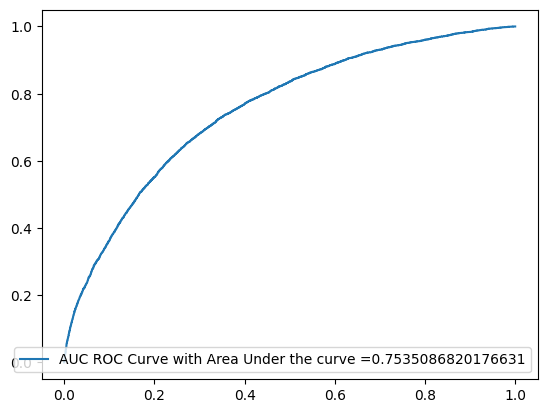

Logistic: f1=0.039 auc=0.233


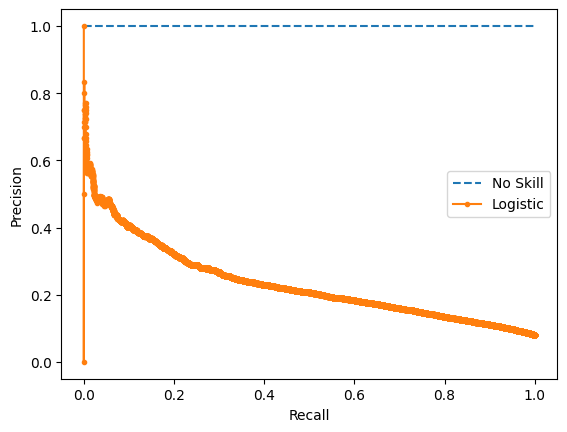

+------------------+---------------------+---------------------+
| Confusion Matrix | Positive prediction | Negative prediction |
+------------------+---------------------+---------------------+
|  Positive class  |  True positive (TP) | False negative (FN) |
|  Negative class  | False positive (FP) |  True negative (TN) |
+------------------+---------------------+---------------------+
+------------------+---------------------+---------------------+
| Confusion Matrix | Positive prediction | Negative prediction |
+------------------+---------------------+---------------------+
|  Positive class  |          98         |         4786        |
|  Negative class  |          84         |        56535        |
+------------------+---------------------+---------------------+
ROC AUC:  0.5092909595770826
Accuracy =  0.9208168707217534
Precision =  0.5384615384615384
Recall =  0.020065520065520065
F1 Score =  0.038689301223845236
Fbeta Score =  (0.5, 0.92, 0.91)
  model     tn  fp    fn  tp  F

In [157]:
XGB_metrics, best_XGB  = generate_model_report(best_xgb_model, run_name, X_test, Y_test, timeXGB)
run_MLflow(experiment_name, run_name, XGB_metrics, best_xgb_params, best_xgb_model, X_train)

**2/6 RUN XGB with SMOTE data**

START time Wed Feb 28 10:01:22 2024
start RandomizedSearchCV 
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/Users/markobriesemann/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:307: UserWarning: The total space of parameters 6 is smaller than n_iter=100. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[CV 2/5] END colsample_bytree=0.3, learning_rate=0.1, max_depth=6, n_estimators=170, subsample=0.3;, score=0.727 total time=  59.5s
[CV 5/5] END colsample_bytree=0.3, learning_rate=0.1, max_depth=6, n_estimators=180, subsample=0.3;, score=0.752 total time=  59.9s


/Users/markobriesemann/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV 1/5] END colsample_bytree=0.3, learning_rate=0.1, max_depth=6, n_estimators=175, subsample=0.3;, score=0.720 total time= 1.0min
[CV 2/5] END colsample_bytree=0.3, learning_rate=0.1, max_depth=6, n_estimators=185, subsample=0.3;, score=0.726 total time= 1.1min
[CV 4/5] END colsample_bytree=0.3, learning_rate=0.1, max_depth=6, n_estimators=195, subsample=0.3;, score=0.716 total time=  46.7s
START time Wed Feb 28 10:01:22 2024
END time Wed Feb 28 10:04:36 2024  duration 3.245553497473399 min

---------------------------------
start generate_model_report


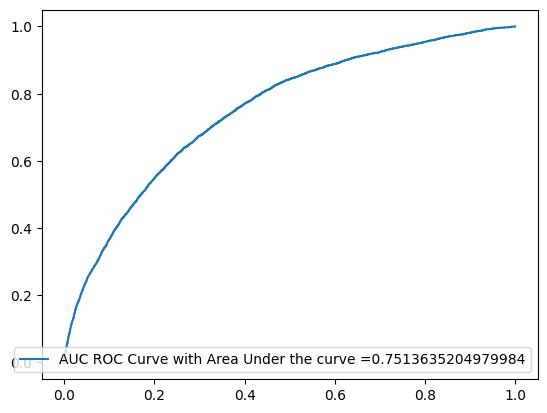

Logistic: f1=0.291 auc=0.232


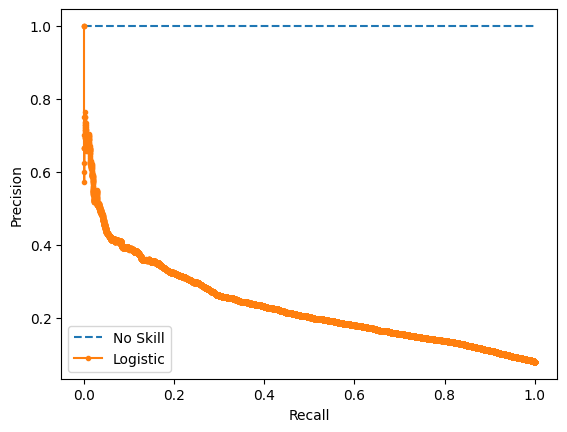

+------------------+---------------------+---------------------+
| Confusion Matrix | Positive prediction | Negative prediction |
+------------------+---------------------+---------------------+
|  Positive class  |  True positive (TP) | False negative (FN) |
|  Negative class  | False positive (FP) |  True negative (TN) |
+------------------+---------------------+---------------------+
+------------------+---------------------+---------------------+
| Confusion Matrix | Positive prediction | Negative prediction |
+------------------+---------------------+---------------------+
|  Positive class  |         1834        |         3050        |
|  Negative class  |         5886        |        50733        |
+------------------+---------------------+---------------------+
ROC AUC:  0.6357769201116841
Accuracy =  0.8547062744906753
Precision =  0.23756476683937824
Recall =  0.37551187551187554
F1 Score =  0.29101872421453506
Fbeta Score =  (0.62, 0.85, 0.86)
       model     tn    fp    fn

/Users/markobriesemann/opt/anaconda3/lib/python3.8/site-packages/mlflow/models/signature.py:212: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input) if model_input is not None else None


Artifact PATH XGB_smote_artifactPATH
{'TN': 38327, 'FP': 18292, 'FN': 1482, 'TP': 3402, 'FP_10_FN': 33112, 'Accuracy': 0.6784872282652878, 'F1': 0.256001204003311, 'Precision': 0.15681755324052735, 'Recall': 0.6965601965601965, 'ROC_AUC': 0.6867442180985338, 'threshold': 0.3, 'time_in_s': 194.73320984840393}
{'subsample': 0.3, 'n_estimators': 195, 'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 0.3}
Active run_id: ecaf399e6500430c9377d5baf31e5f8e
[CV 1/5] END colsample_bytree=0.3, learning_rate=0.1, max_depth=6, n_estimators=180, subsample=0.3;, score=0.719 total time= 1.1min
[CV 4/5] END colsample_bytree=0.3, learning_rate=0.1, max_depth=6, n_estimators=185, subsample=0.3;, score=0.714 total time= 1.1min
[CV 5/5] END colsample_bytree=0.3, learning_rate=0.1, max_depth=6, n_estimators=175, subsample=0.3;, score=0.752 total time= 1.0min
[CV 5/5] END colsample_bytree=0.3, learning_rate=0.1, max_depth=6, n_estimators=185, subsample=0.3;, score=0.753 total time= 1.1min
[CV 4/5] EN

In [114]:
# XGB with SMOTE data   
run_name = "XGB_smote"
XGB_model_smote, best_xfb_params_smote, timeXGBsmote =  train_XGBoost_model(x_train_smote, y_train_smote)
XGB_smote_metrics     = generate_model_report(XGB_model_smote, run_name, X_test, Y_test)
best_metrics_XGB_smote, metrics_XGB_smote = find_optimal_business_score(XGB_model_smote, run_name, X_test, Y_test, timeXGBsmote)
signature_XGB_smote     = infer_signature(X_train, best_xgb_model.predict(X_train))
run_MLflow(experiment_name, run_name, metrics_XGB_smote, best_xfb_params_smote, XGB_model_smote, signature_XGB_smote)

**3/6 LightGBM on unbalanced data set**

START time Wed Feb 28 10:59:29 2024
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/markobriesemann/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:307: UserWarning: The total space of parameters 1 is smaller than n_iter=50. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/Users/markobriesemann/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/markobriesemann/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 19941, number of negative: 226067
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.053448 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11501
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 232
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
START time Wed Feb 28 10:59:29 2024
END time Wed Feb 28 11:07:48 2024  duration 8.324515279134115 min

---------------------------------
start generate_model_report


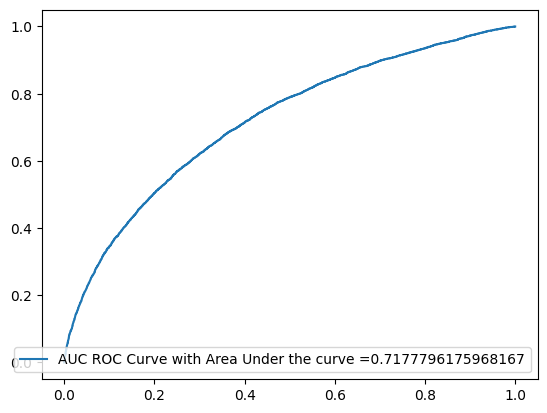

Logistic: f1=0.268 auc=0.207


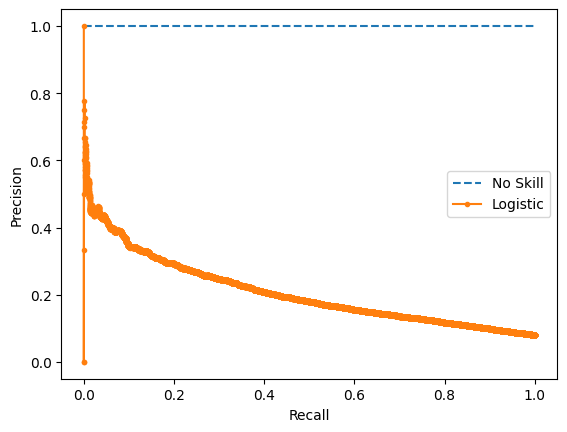

+------------------+---------------------+---------------------+
| Confusion Matrix | Positive prediction | Negative prediction |
+------------------+---------------------+---------------------+
|  Positive class  |  True positive (TP) | False negative (FN) |
|  Negative class  | False positive (FP) |  True negative (TN) |
+------------------+---------------------+---------------------+
+------------------+---------------------+---------------------+
| Confusion Matrix | Positive prediction | Negative prediction |
+------------------+---------------------+---------------------+
|  Positive class  |         1389        |         3495        |
|  Negative class  |         4105        |        52514        |
+------------------+---------------------+---------------------+
ROC AUC:  0.6059479354066859
Accuracy =  0.8764287920914426
Precision =  0.25282125955587914
Recall =  0.2843980343980344
F1 Score =  0.26768163422624786
Fbeta Score =  (0.6, 0.88, 0.88)
      model     tn    fp    fn   

/Users/markobriesemann/opt/anaconda3/lib/python3.8/site-packages/mlflow/models/signature.py:212: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input) if model_input is not None else None


Artifact PATH LightGBM_artifactPATH
{'TN': 41184, 'FP': 15435, 'FN': 1998, 'TP': 2886, 'FP_10_FN': 35415, 'Accuracy': 0.7165504121750158, 'F1': 0.24873949579831933, 'Precision': 0.157524152611757, 'Recall': 0.5909090909090909, 'ROC_AUC': 0.659148711723819, 'threshold': 0.2, 'time_in_s': 499.4709167480469}
{'subsample': 0.8, 'reg_lambda': 0.1, 'reg_alpha': 0.1, 'objective': 'binary', 'num_leaves': 31, 'n_estimators': 10000, 'metric': 'binary_logloss', 'learning_rate': 0.05, 'class_weight': 'balanced', 'boosting_type': 'gbdt'}
Active run_id: 626326a511304ac2aee373ba9aa7ecf7
[LightGBM] [Info] Number of positive: 15952, number of negative: 180854
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.088020 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11420
[LightGBM] [Info] Number of data points in the train set: 196806, number of used feature

/Users/markobriesemann/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/markobriesemann/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 15953, number of negative: 180853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.220842 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11495
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 230
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[CV 2/5] END boosting_type=gbdt, class_weight=balanced, learning_rate=0.05, metric=binary_logloss, n_estimators=10000, num_leaves=31, objective=binary, reg_alpha=0.1, reg_lambda=0.1, subsample=0.8;, score=0.883 total time= 6.6min


/Users/markobriesemann/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/markobriesemann/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 15953, number of negative: 180853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.093408 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11406
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 230
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[CV 3/5] END boosting_type=gbdt, class_weight=balanced, learning_rate=0.05, metric=binary_logloss, n_estimators=10000, num_leaves=31, objective=binary, reg_alpha=0.1, reg_lambda=0.1, subsample=0.8;, score=0.886 total time= 6.7min


/Users/markobriesemann/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/markobriesemann/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 15953, number of negative: 180854
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.122120 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11428
[LightGBM] [Info] Number of data points in the train set: 196807, number of used features: 230
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[CV 5/5] END boosting_type=gbdt, class_weight=balanced, learning_rate=0.05, metric=binary_logloss, n_estimators=10000, num_leaves=31, objective=binary, reg_alpha=0.1, reg_lambda=0.1, subsample=0.8;, score=0.886 total time= 7.2min


/Users/markobriesemann/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/markobriesemann/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 15953, number of negative: 180854
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.117098 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11491
[LightGBM] [Info] Number of data points in the train set: 196807, number of used features: 232
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[CV 4/5] END boosting_type=gbdt, class_weight=balanced, learning_rate=0.05, metric=binary_logloss, n_estimators=10000, num_leaves=31, objective=binary, reg_alpha=0.1, reg_lambda=0.1, subsample=0.8;, score=0.885 total time= 7.2min


/Users/markobriesemann/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/markobriesemann/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


In [116]:
run_name = "LightGBM"
LGBM_model, best_LGBM_params, time_LGBM =  train_LightGBM_model(X_train, Y_train)
LGBM_metrics     = generate_model_report(LGBM_model, run_name, X_test, Y_test)
best_metrics_LGBM, metrics_LGBM = find_optimal_business_score(LGBM_model, run_name, X_test, Y_test, time_LGBM)
signature_LGBM     = infer_signature(X_train, LGBM_model.predict(X_train))
run_MLflow(experiment_name, run_name, metrics_LGBM, best_LGBM_params, LGBM_model, signature_LGBM)

**4/6 LightGBM on smote data set**

START time Wed Feb 28 13:19:30 2024
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/markobriesemann/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:307: UserWarning: The total space of parameters 1 is smaller than n_iter=50. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[LightGBM] [Info] Number of positive: 22606, number of negative: 45212
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018822 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15832
[LightGBM] [Info] Number of data points in the train set: 67818, number of used features: 226
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
START time Wed Feb 28 13:19:30 2024
END time Wed Feb 28 13:24:32 2024  duration 5.034470983346304 min

---------------------------------
start generate_model_report


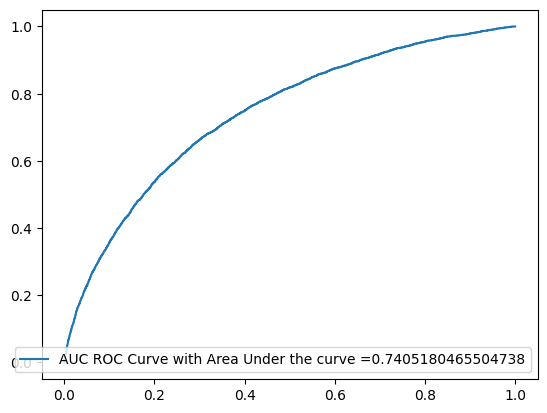

Logistic: f1=0.285 auc=0.215


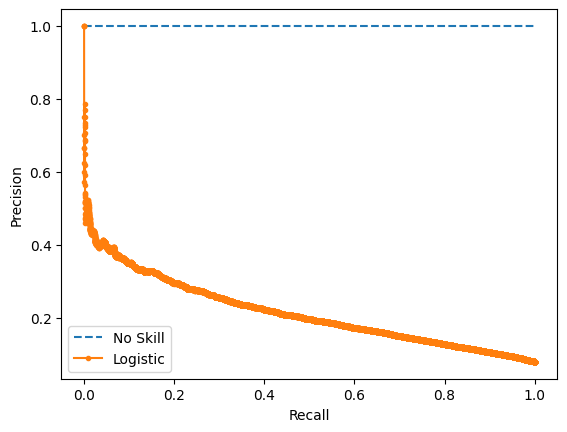

+------------------+---------------------+---------------------+
| Confusion Matrix | Positive prediction | Negative prediction |
+------------------+---------------------+---------------------+
|  Positive class  |  True positive (TP) | False negative (FN) |
|  Negative class  | False positive (FP) |  True negative (TN) |
+------------------+---------------------+---------------------+
+------------------+---------------------+---------------------+
| Confusion Matrix | Positive prediction | Negative prediction |
+------------------+---------------------+---------------------+
|  Positive class  |         2304        |         2580        |
|  Negative class  |         8978        |        47641        |
+------------------+---------------------+---------------------+
ROC AUC:  0.6565878966928085
Accuracy =  0.8120742077622229
Precision =  0.20421911008686403
Recall =  0.47174447174447176
F1 Score =  0.2850426821724607
Fbeta Score =  (0.62, 0.81, 0.82)
            model     tn    fp  

/Users/markobriesemann/opt/anaconda3/lib/python3.8/site-packages/mlflow/models/signature.py:212: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input) if model_input is not None else None


Artifact PATH LightGBM_smote_artifactPATH
{'TN': 41184, 'FP': 15435, 'FN': 1998, 'TP': 2886, 'FP_10_FN': 35415, 'Accuracy': 0.7165504121750158, 'F1': 0.24873949579831933, 'Precision': 0.157524152611757, 'Recall': 0.5909090909090909, 'ROC_AUC': 0.659148711723819, 'threshold': 0.2, 'time_in_s': 302.0682590007782}
{'subsample': 0.8, 'reg_lambda': 0.1, 'reg_alpha': 0.1, 'objective': 'binary', 'num_leaves': 31, 'n_estimators': 10000, 'metric': 'binary_logloss', 'learning_rate': 0.05, 'class_weight': 'balanced', 'boosting_type': 'gbdt'}
Active run_id: 5392693623854f9bab8fa86a3492992c
[LightGBM] [Info] Number of positive: 18085, number of negative: 36170
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025932 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10944
[LightGBM] [Info] Number of data points in the train set: 54255, number of used fea

In [121]:
run_name = "LightGBM_smote"
LGBM_smote_model, best_LGBM_smote_params, time_LGBM_smote =  train_LightGBM_model(x_train_smote, y_train_smote)
LGBM_smote_metrics     = generate_model_report(LGBM_smote_model, run_name, X_test, Y_test)
best_metrics_LGBM_smote, metrics_LGBM_smote = find_optimal_business_score(LGBM_model, run_name, X_test, Y_test, time_LGBM_smote)
signature_LGBM_smote     = infer_signature(X_train, LGBM_smote_model.predict(x_train_smote))
run_MLflow(experiment_name, run_name, metrics_LGBM_smote, best_LGBM_smote_params,
           LGBM_smote_model, signature_LGBM_smote)

**5/6 RFC on unbalanced data set**

START time Thu Feb 29 11:07:31 2024


/Users/markobriesemann/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/markobriesemann/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/markobriesemann/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/markobriesemann/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1

/Users/markobriesemann/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/markobriesemann/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/markobriesemann/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/markobriesemann/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y wa

Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}
START time Thu Feb 29 11:07:31 2024
END time Thu Feb 29 14:59:32 2024  duration 232.01866473356884 min

---------------------------------
start generate_model_report


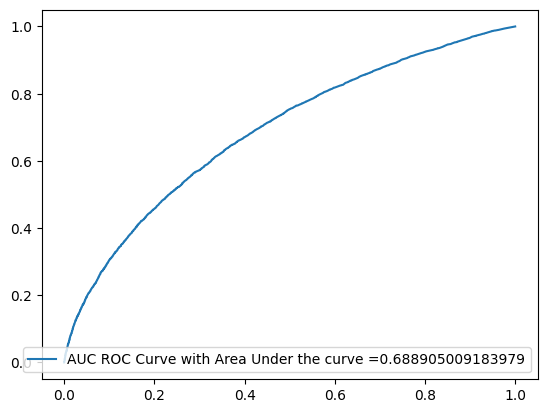

Logistic: f1=0.001 auc=0.182


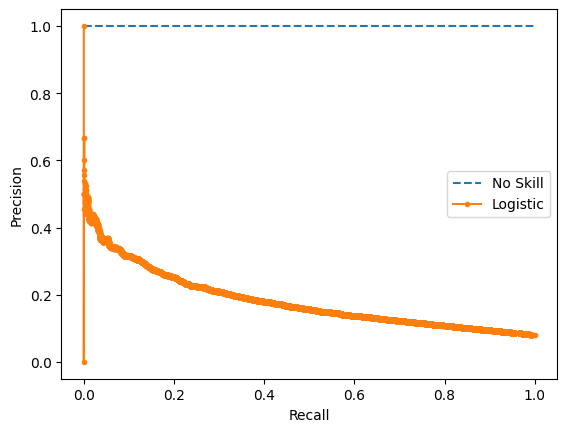

+------------------+---------------------+---------------------+
| Confusion Matrix | Positive prediction | Negative prediction |
+------------------+---------------------+---------------------+
|  Positive class  |  True positive (TP) | False negative (FN) |
|  Negative class  | False positive (FP) |  True negative (TN) |
+------------------+---------------------+---------------------+
+------------------+---------------------+---------------------+
| Confusion Matrix | Positive prediction | Negative prediction |
+------------------+---------------------+---------------------+
|  Positive class  |          3          |         4881        |
|  Negative class  |          2          |        56617        |
+------------------+---------------------+---------------------+
ROC AUC:  0.5002894633915139
Accuracy =  0.920605498918752
Precision =  0.6
Recall =  0.0006142506142506142
F1 Score =  0.0012272448353446513
Fbeta Score =  (0.49, 0.92, 0.91)
  model     tn  fp    fn  tp  FP+10*FN  accu

/Users/markobriesemann/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/markobriesemann/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/markobriesemann/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/markobriesemann/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y wa

/Users/markobriesemann/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/markobriesemann/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/markobriesemann/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/markobriesemann/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y wa

/Users/markobriesemann/opt/anaconda3/lib/python3.8/site-packages/mlflow/models/signature.py:212: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input) if model_input is not None else None


Active run_id: 2bfc23fec1f84b3ea83ec0509b0fe560


In [133]:
run_name = "RFC"
RFC_model, best_RFC_params, time_RFC = RFC_model(X_train, Y_train)
RFC_metrics, best_metrics_RFC        = generate_model_report(RFC_model, run_name, X_test, Y_test, time_RFC)
run_MLflow(experiment_name, run_name, RFC_metrics, 
           best_RFC_params, RFC_model, X_train)

**6/6 RFC on Smote data set**

START time Thu Feb 29 10:41:45 2024


/Users/markobriesemann/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
START time Thu Feb 29 10:41:45 2024
END time Thu Feb 29 11:06:55 2024  duration 25.16940438747406 min

---------------------------------
start generate_model_report


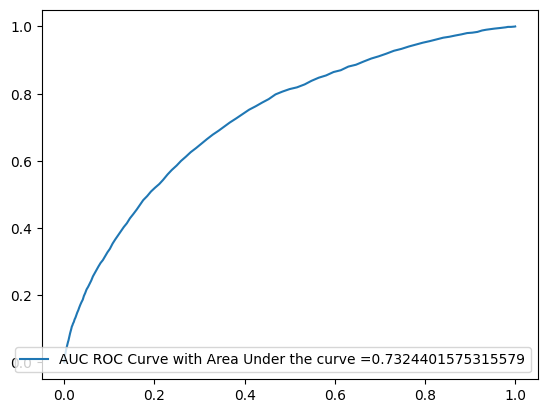

Logistic: f1=0.252 auc=0.211


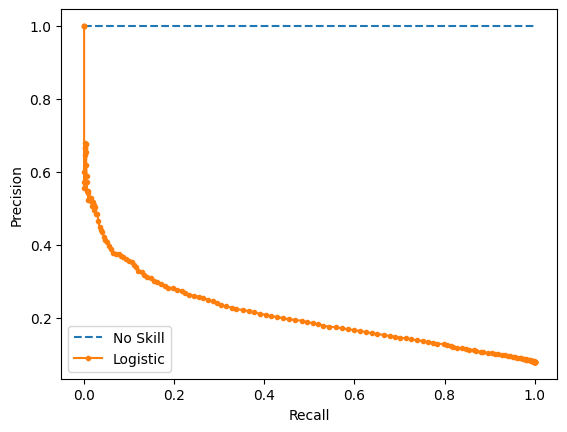

+------------------+---------------------+---------------------+
| Confusion Matrix | Positive prediction | Negative prediction |
+------------------+---------------------+---------------------+
|  Positive class  |  True positive (TP) | False negative (FN) |
|  Negative class  | False positive (FP) |  True negative (TN) |
+------------------+---------------------+---------------------+
+------------------+---------------------+---------------------+
| Confusion Matrix | Positive prediction | Negative prediction |
+------------------+---------------------+---------------------+
|  Positive class  |         1192        |         3692        |
|  Negative class  |         3392        |        53227        |
+------------------+---------------------+---------------------+
ROC AUC:  0.5920765131542431
Accuracy =  0.8848186267336553
Precision =  0.2600349040139616
Recall =  0.24406224406224405
F1 Score =  0.251795521757499
Fbeta Score =  (0.59, 0.88, 0.88)
       model     tn    fp    fn   

/Users/markobriesemann/opt/anaconda3/lib/python3.8/site-packages/mlflow/models/signature.py:212: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input) if model_input is not None else None


Active run_id: b847bbc297a34b9ebd42cc3d7c4254f5


In [132]:
run_name = "RFC_smote"
RFC_model_smote, best_RFC_params_smote, time_RFC_smote = RFC_model(x_train_smote, y_train_smote)
RFC_smote_metrics, best_metrics_RFC_smote              = generate_model_report(RFC_model_smote, run_name, X_test, Y_test, time_RFC_smote)
run_MLflow(experiment_name, run_name, RFC_smote_metrics, 
           best_RFC_params_smote, RFC_model_smote, x_train_smote)

<a name='4'></a>
# 5 Evalutation and selection of best model

In [254]:
# Get the experiment by name
experiment = mlflow.get_experiment_by_name(experiment_name)

# Get all runs within the experiment
runs = mlflow.search_runs(experiment_ids=[experiment.experiment_id])

# Create an empty list to store metrics data
metrics_data = []

# Iterate over each run and append its metrics to the list
for index, run in runs.iterrows():
    run_id = run["run_id"]
    run_info = mlflow.get_run(run_id)
    run_name = run_info.data.tags.get("mlflow.runName")
    metrics = run_info.data.metrics
    metrics_data.append({**metrics, "Run Name": run_name})

# Create a DataFrame from the metrics data
metrics_df = pd.DataFrame(metrics_data)
metrics_df.set_index("Run Name", inplace=True)  # Set the run name as the index

print(metrics_df)

                       time_in_s  FP_10_FN       FP      TP  Accuracy  \
Run Name                                                                
LGBM_Shap002          508.117909   35429.0  15139.0  2855.0  0.720859   
RFC_newFEATURE_001  13614.842443   36741.0  19881.0  3198.0  0.649334   
XGB_Shap002           401.376422   32718.0  12948.0  2907.0  0.757329   
RFC_newFEATURE_002   5635.813629   35370.0  17020.0  3049.0  0.693430   
RFC_newFEATURE      12256.283958   36534.0  19814.0  3212.0  0.650651   
XGB                 26824.582238   32675.0  12635.0  2880.0  0.761979   
RFC                 13921.119884   37986.0  18046.0  2890.0  0.674162   
RFC_smote            1510.164263   35067.0  10407.0  2418.0  0.790693   
LightGBM_smote        302.068259   35415.0  15435.0  2886.0  0.716550   
LightGBM              499.470917   35415.0  15435.0  2886.0  0.716550   
XGB_smote             194.733210   33112.0  18292.0  3402.0  0.678487   

                      Recall  threshold   ROC_AUC 

The model **XGB** receives the best business score (FP_10_FN) with 32675, at the same time it has the second highest Accuracy and the second highest Precision.

<a name='6'></a>
# 6 Feature Importance

- get feature importance
- select the features with SHAP values equal 0 and retrain model to assess change

In [165]:
#feature_names.iloc[:,0].values.tolist()

In [13]:
feature_importance_df = pd.DataFrame({
    'Feature': feature_names.iloc[:,0].values.tolist(),
    'Importance': RFC_model.feature_importances_
})

# Sorting the DataFrame by importance scores
feature_importance_df_sorted = feature_importance_df.sort_values(by='Importance', ascending=False)

# Displaying the sorted DataFrame
feature_importance_df_sorted['Feature'][:20].tolist()

['EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'DAYS_BIRTH',
 'DAYS_ID_PUBLISH',
 'DAYS_REGISTRATION',
 'DAYS_EMPLOYED',
 'AMT_ANNUITY',
 'DAYS_LAST_PHONE_CHANGE',
 'AMT_CREDIT',
 'AMT_INCOME_TOTAL',
 'AMT_GOODS_PRICE',
 'REGION_POPULATION_RELATIVE',
 'EXT_SOURCE_1',
 'HOUR_APPR_PROCESS_START',
 'AMT_REQ_CREDIT_BUREAU_YEAR',
 'OWN_CAR_AGE',
 'OBS_30_CNT_SOCIAL_CIRCLE',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'TOTALAREA_MODE',
 'LIVINGAREA_MODE']

In [142]:
# Select columns with data type 'int64'
int_columns = X_train.select_dtypes(include=['int64']).columns

# Convert selected columns to int
X_train[int_columns] = X_train[int_columns].astype('float')
# Select columns with data type 'int64'
int_columns = X_train.select_dtypes(include=['bool']).columns

# Convert selected columns to int
X_train[int_columns] = X_train[int_columns].astype('float')
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 246008 entries, 0 to 246007
Columns: 239 entries, 0 to 238
dtypes: float64(239)
memory usage: 448.6 MB


**Conversion of type of the test data**

In [ ]:
test = X_train.copy()
test["ID"] = ids_test
test.set_index("ID", inplace=True)
ids_test.iloc[5]
#test.loc[100008].values.tolist()
data_point = test.loc[100030].values.tolist()


In [ ]:
explainer = shap.Explainer(best_xgb_model, X_train)

shap_values = explainer.shap_values(data_point)
shap_df = pd.DataFrame({'Feature': X.columns, 'SHAP Value': shap_values[0]})
print("\nSHAP Values:")
print(shap_df)

In [232]:
explainer = shap.Explainer(best_xgb_model, X_train)

shap_values = explainer.shap_values(X_train)
shap_df = pd.DataFrame({'Feature': feature_names['0'].tolist(), 'SHAP Value': shap_values[0]})
print("\n SHAP Values:")
# Sort shap_df by the 'SHAP Value' column in ascending order
sorted_shap_df = shap_df.sort_values(by='SHAP Value')

# Print the sorted DataFrame
print(sorted_shap_df)

 10%|==                  | 25527/246008 [15:49<136:36]       

[CV 2/5] END colsample_bytree=0.3, learning_rate=0.1, max_depth=6, n_estimators=170, subsample=0.3;, score=0.919 total time= 2.3min
[CV 2/5] END colsample_bytree=0.3, learning_rate=0.1, max_depth=6, n_estimators=185, subsample=0.3;, score=0.919 total time= 2.5min
[CV 3/5] END colsample_bytree=0.3, learning_rate=0.1, max_depth=6, n_estimators=195, subsample=0.3;, score=0.919 total time= 1.5min
[CV 3/5] END colsample_bytree=0.3, learning_rate=0.1, max_depth=6, n_estimators=170, subsample=0.3;, score=0.919 total time= 2.3min
[CV 4/5] END colsample_bytree=0.3, learning_rate=0.1, max_depth=6, n_estimators=180, subsample=0.3;, score=0.919 total time= 2.5min
[CV 5/5] END colsample_bytree=0.3, learning_rate=0.1, max_depth=6, n_estimators=190, subsample=0.3;, score=0.919 total time= 1.5min
[CV 4/5] END colsample_bytree=0.3, learning_rate=0.1, max_depth=6, n_estimators=175, subsample=0.3;, score=0.919 total time= 2.4min
[CV 4/5] END colsample_bytree=0.3, learning_rate=0.1, max_depth=6, n_estimat

 10%|==                  | 25721/246008 [15:51<135:44]       

[CV 4/5] END colsample_bytree=0.3, learning_rate=0.1, max_depth=6, n_estimators=170, subsample=0.3;, score=0.919 total time= 2.3min
[CV 5/5] END colsample_bytree=0.3, learning_rate=0.1, max_depth=6, n_estimators=180, subsample=0.3;, score=0.919 total time= 2.5min
[CV 2/5] END colsample_bytree=0.3, learning_rate=0.1, max_depth=6, n_estimators=195, subsample=0.3;, score=0.919 total time= 1.5min


 11%|==                  | 25833/246008 [15:52<135:13]       

[CV 1/5] END colsample_bytree=0.3, learning_rate=0.1, max_depth=6, n_estimators=170, subsample=0.3;, score=0.919 total time= 2.3min
[CV 1/5] END colsample_bytree=0.3, learning_rate=0.1, max_depth=6, n_estimators=185, subsample=0.3;, score=0.919 total time= 2.5min
[CV 4/5] END colsample_bytree=0.3, learning_rate=0.1, max_depth=6, n_estimators=195, subsample=0.3;, score=0.919 total time= 1.5min


 11%|==                  | 25936/246008 [15:53<134:46]       

[CV 1/5] END colsample_bytree=0.3, learning_rate=0.1, max_depth=6, n_estimators=175, subsample=0.3;, score=0.919 total time= 2.4min
[CV 1/5] END colsample_bytree=0.3, learning_rate=0.1, max_depth=6, n_estimators=190, subsample=0.3;, score=0.919 total time= 2.6min
[CV 1/5] END colsample_bytree=0.3, learning_rate=0.1, max_depth=6, n_estimators=180, subsample=0.3;, score=0.919 total time= 2.4min
[CV 3/5] END colsample_bytree=0.3, learning_rate=0.1, max_depth=6, n_estimators=190, subsample=0.3;, score=0.919 total time= 2.6min


 11%|==                  | 26350/246008 [15:56<132:49]       

[CV 3/5] END colsample_bytree=0.3, learning_rate=0.1, max_depth=6, n_estimators=175, subsample=0.3;, score=0.919 total time= 2.4min
[CV 2/5] END colsample_bytree=0.3, learning_rate=0.1, max_depth=6, n_estimators=190, subsample=0.3;, score=0.919 total time= 2.6min


 12%|==                  | 28833/246008 [16:13<122:08]       

[CV 5/5] END colsample_bytree=0.3, learning_rate=0.1, max_depth=6, n_estimators=175, subsample=0.3;, score=0.919 total time= 2.4min
[CV 3/5] END colsample_bytree=0.3, learning_rate=0.1, max_depth=6, n_estimators=185, subsample=0.3;, score=0.919 total time= 2.5min


 29%|======              | 70477/246008 [20:50<51:53]        

[CV 2/5] END colsample_bytree=0.3, learning_rate=0.1, max_depth=6, n_estimators=180, subsample=0.3;, score=0.919 total time= 2.4min
[CV 4/5] END colsample_bytree=0.3, learning_rate=0.1, max_depth=6, n_estimators=190, subsample=0.3;, score=0.919 total time= 2.6min
[CV 2/5] END colsample_bytree=0.3, learning_rate=0.1, max_depth=6, n_estimators=175, subsample=0.3;, score=0.919 total time= 2.4min
[CV 5/5] END colsample_bytree=0.3, learning_rate=0.1, max_depth=6, n_estimators=185, subsample=0.3;, score=0.919 total time= 2.5min
[CV 5/5] END colsample_bytree=0.3, learning_rate=0.1, max_depth=6, n_estimators=195, subsample=0.3;, score=0.919 total time= 1.4min


 29%|======              | 70630/246008 [20:51<51:46]       

[CV 5/5] END colsample_bytree=0.3, learning_rate=0.1, max_depth=6, n_estimators=170, subsample=0.3;, score=0.919 total time= 2.3min
[CV 3/5] END colsample_bytree=0.3, learning_rate=0.1, max_depth=6, n_estimators=180, subsample=0.3;, score=0.919 total time= 2.5min
[CV 1/5] END colsample_bytree=0.3, learning_rate=0.1, max_depth=6, n_estimators=195, subsample=0.3;, score=0.919 total time= 1.5min


100%|===================| 245994/246008 [41:00<00:00]        


 SHAP Values:
                                               Feature  SHAP Value
9                                           DAYS_BIRTH   -0.333566
48                                   BASEMENTAREA_MODE   -0.041073
18                                          FLAG_PHONE   -0.025144
38                                       ELEVATORS_AVG   -0.019287
106                         AMT_REQ_CREDIT_BUREAU_YEAR   -0.017173
16                                     FLAG_WORK_PHONE   -0.017127
58                                     LIVINGAREA_MODE   -0.016472
71                               LIVINGAPARTMENTS_MEDI   -0.015468
80                              DAYS_LAST_PHONE_CHANGE   -0.013490
12                                     DAYS_ID_PUBLISH   -0.013208
43                                LIVINGAPARTMENTS_AVG   -0.012375
6                                          AMT_ANNUITY   -0.012227
36                                     YEARS_BUILD_AVG   -0.009523
27                              REG_CITY_NOT_LI

In [162]:
pd.set_option('display.max_rows', None)  # Show all rows
shap_df = pd.DataFrame({'Feature': feature_names['0'].tolist(), 'SHAP Value': shap_values[0]})
print("\n SHAP Values:")
# Sort shap_df by the 'SHAP Value' column in ascending order
sorted_shap_df = shap_df.sort_values(by='SHAP Value')

# Print the sorted DataFrame
print(sorted_shap_df)


 SHAP Values:
                                               Feature  SHAP Value
9                                           DAYS_BIRTH   -0.333566
48                                   BASEMENTAREA_MODE   -0.041073
18                                          FLAG_PHONE   -0.025144
38                                       ELEVATORS_AVG   -0.019287
106                         AMT_REQ_CREDIT_BUREAU_YEAR   -0.017173
16                                     FLAG_WORK_PHONE   -0.017127
58                                     LIVINGAREA_MODE   -0.016472
71                               LIVINGAPARTMENTS_MEDI   -0.015468
80                              DAYS_LAST_PHONE_CHANGE   -0.013490
12                                     DAYS_ID_PUBLISH   -0.013208
43                                LIVINGAPARTMENTS_AVG   -0.012375
6                                          AMT_ANNUITY   -0.012227
36                                     YEARS_BUILD_AVG   -0.009523
27                              REG_CITY_NOT_LI

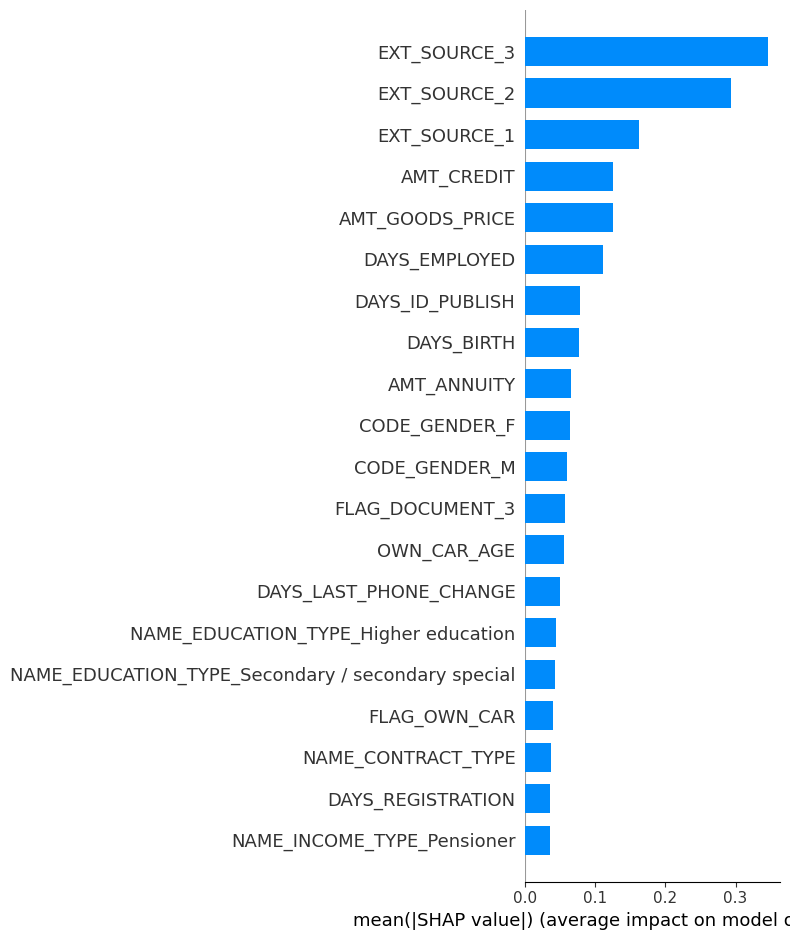

In [155]:
shap.summary_plot(shap_values, shap_df['Feature'], plot_type="bar")

In [ ]:
#!pip freeze > requirements.txt

<a name='7'></a>
## 7 Feature Selection after SHAP feature Importance

## Filter not useful features

In [178]:
# Displaying the sorted DataFrame
SHAP_feature_important_001 = shap_df[abs(shap_df['SHAP Value'])>0.001]['Feature'].tolist()
len(SHAP_feature_important)

(76, 2)


115

Retrain

In [175]:
len(SHAP_feature_unimportant)

76

In [184]:
len(SHAP_feature_important)

115

In [209]:
#SHAP_feature_important

In [237]:
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,229,230,231,232,233,234,235,236,237,238
0,0.0,0.0,1.0,0.0,202500.0,406597.5,24700.5,351000.0,0.018801,9461.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,270000.0,1293502.5,35698.5,1129500.0,0.003541,16765.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1.0,1.0,1.0,0.0,67500.0,135000.0,6750.0,135000.0,0.010032,19046.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,135000.0,312682.5,29686.5,297000.0,0.008019,19005.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,121500.0,513000.0,21865.5,513000.0,0.028663,19932.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [249]:
def select_columns(X_train, feature_names, shap_df, threshold):
    SHAP_feature_important = shap_df[abs(shap_df['SHAP Value'])>threshold]['Feature'].tolist()
    print("length important features ", len(SHAP_feature_important))
    df = X_train.copy()
    df.columns = feature_names['0'].tolist()
    df = df[SHAP_feature_important]
    # Remove all column names
    #df.rename(columns={x:y for x,y in zip(df.columns,range(0,len(df.columns)))})
    df.columns = [x for x in range(0, len(df.columns))] 
    print(df.shape)
    #print(df.info())
    print(df.head())
    return df

### First attempt to improve feature selection and model training

In [202]:
new_X_train = select_columns(X_train, feature_names, shap_df, 0.001)
new_X_test  = select_columns(X_test, feature_names, shap_df, 0.001)

(246008, 115)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 246008 entries, 0 to 246007
Columns: 115 entries, NAME_CONTRACT_TYPE to DAYS_EMPLOYED_ANOM
dtypes: float64(115)
memory usage: 215.8 MB
None
(61503, 115)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61503 entries, 0 to 61502
Columns: 115 entries, NAME_CONTRACT_TYPE to DAYS_EMPLOYED_ANOM
dtypes: bool(37), float64(58), int64(20)
memory usage: 38.8 MB
None


START time Sat Mar  2 18:28:36 2024


/Users/markobriesemann/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/markobriesemann/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
/Users/markobriesemann/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)

/Users/markobriesemann/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/markobriesemann/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/markobriesemann/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/markobriesemann/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y wa

/Users/markobriesemann/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/markobriesemann/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/markobriesemann/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/markobriesemann/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y wa

/Users/markobriesemann/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/markobriesemann/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/markobriesemann/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/markobriesemann/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y wa

/Users/markobriesemann/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/markobriesemann/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/markobriesemann/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/markobriesemann/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y wa

/Users/markobriesemann/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/markobriesemann/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/markobriesemann/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/markobriesemann/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y wa

/Users/markobriesemann/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/markobriesemann/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/markobriesemann/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/markobriesemann/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y wa

/Users/markobriesemann/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/markobriesemann/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/markobriesemann/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/markobriesemann/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y wa

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/Users/markobriesemann/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/markobriesemann/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/markobriesemann/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs

/Users/markobriesemann/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/markobriesemann/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/markobriesemann/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/markobriesemann/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y wa

/Users/markobriesemann/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/markobriesemann/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/markobriesemann/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/markobriesemann/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y wa

Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
START time Sat Mar  2 18:28:36 2024
END time Sat Mar  2 22:15:31 2024  duration 226.91404071648915 min

---------------------------------
start generate_model_report


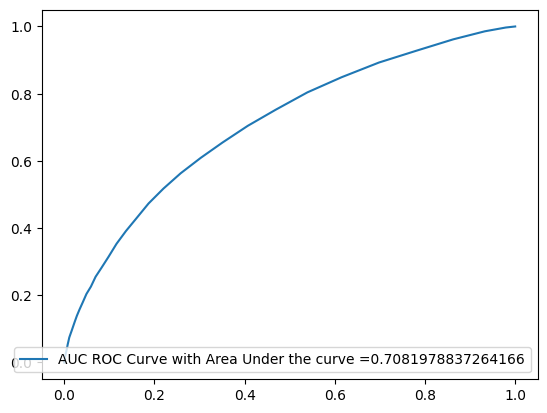

Logistic: f1=0.002 auc=0.194


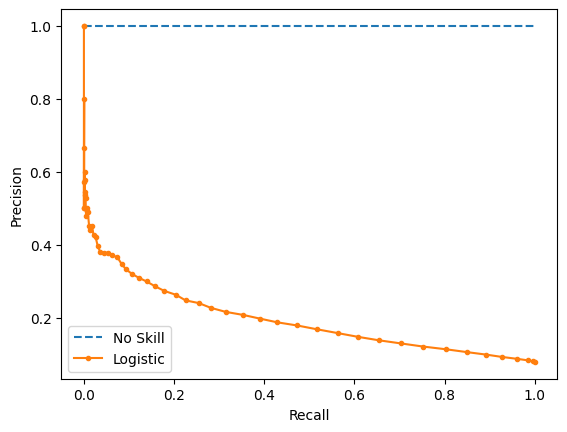

+------------------+---------------------+---------------------+
| Confusion Matrix | Positive prediction | Negative prediction |
+------------------+---------------------+---------------------+
|  Positive class  |  True positive (TP) | False negative (FN) |
|  Negative class  | False positive (FP) |  True negative (TN) |
+------------------+---------------------+---------------------+
+------------------+---------------------+---------------------+
| Confusion Matrix | Positive prediction | Negative prediction |
+------------------+---------------------+---------------------+
|  Positive class  |          4          |         4880        |
|  Negative class  |          3          |        56616        |
+------------------+---------------------+---------------------+
ROC AUC:  0.5003830075360833
Accuracy =  0.920605498918752
Precision =  0.5714285714285714
Recall =  0.000819000819000819
F1 Score =  0.0016356573297894093
Fbeta Score =  (0.49, 0.92, 0.91)
                model     tn  

In [234]:
run_name = "RFC_newFEATURE_001"
RFC_model_001, best_RFC_params, time_RFC = RFC_model(new_X_train, Y_train)
RFC_metrics, best_metrics_RFC        = generate_model_report(RFC_model_001, run_name, new_X_test, Y_test, time_RFC)
run_MLflow(experiment_name, run_name, RFC_metrics, 
           best_RFC_params, RFC_model_001, new_X_train)

### Second attempt to improve feature selection and model improvement

In [253]:
new_X_train_002 = select_columns(X_train, feature_names, shap_df, 0.002)
new_X_test_002  = select_columns(X_test, feature_names, shap_df, 0.002)

X_train_002_scaled, X_test_002_scaled  = scale_data(new_X_train_002, new_X_test_002 )


length important features  96
(246008, 96)
    0    1    2    3         4          5        6          7         8   \
0  0.0  0.0  1.0  0.0  202500.0   406597.5  24700.5   351000.0  0.018801   
1  0.0  0.0  0.0  0.0  270000.0  1293502.5  35698.5  1129500.0  0.003541   
2  1.0  1.0  1.0  0.0   67500.0   135000.0   6750.0   135000.0  0.010032   
3  0.0  0.0  1.0  0.0  135000.0   312682.5  29686.5   297000.0  0.008019   
4  0.0  0.0  1.0  0.0  121500.0   513000.0  21865.5   513000.0  0.028663   

        9   ...   86   87   88   89   90   91   92   93   94   95  
0   9461.0  ...  0.0  1.0  1.0  0.0  0.0  0.0  1.0  1.0  1.0  0.0  
1  16765.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0  
2  19046.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
3  19005.0  ...  0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
4  19932.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 96 columns]
length important features  96
(61503, 96)
   0   1   2   3         4 

NameError: name 'MinMaxScaler' is not defined

[LightGBM] [Info] Number of positive: 15953, number of negative: 180854
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.142028 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10307
[LightGBM] [Info] Number of data points in the train set: 196807, number of used features: 96
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[CV 4/5] END boosting_type=gbdt, class_weight=balanced, learning_rate=0.05, metric=binary_logloss, n_estimators=10000, num_leaves=31, objective=binary, reg_alpha=0.1, reg_lambda=0.1, subsample=0.8;, score=0.886 total time= 5.6min


/Users/markobriesemann/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/markobriesemann/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 15953, number of negative: 180853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.138505 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10304
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 96
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[CV 2/5] END boosting_type=gbdt, class_weight=balanced, learning_rate=0.05, metric=binary_logloss, n_estimators=10000, num_leaves=31, objective=binary, reg_alpha=0.1, reg_lambda=0.1, subsample=0.8;, score=0.883 total time= 7.1min


/Users/markobriesemann/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/markobriesemann/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 15952, number of negative: 180854
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.066573 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10240
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 96
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[CV 1/5] END boosting_type=gbdt, class_weight=balanced, learning_rate=0.05, metric=binary_logloss, n_estimators=10000, num_leaves=31, objective=binary, reg_alpha=0.1, reg_lambda=0.1, subsample=0.8;, score=0.889 total time= 7.1min


/Users/markobriesemann/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/markobriesemann/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 15953, number of negative: 180853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.044952 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10221
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 96
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[CV 3/5] END boosting_type=gbdt, class_weight=balanced, learning_rate=0.05, metric=binary_logloss, n_estimators=10000, num_leaves=31, objective=binary, reg_alpha=0.1, reg_lambda=0.1, subsample=0.8;, score=0.884 total time= 7.1min


/Users/markobriesemann/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/markobriesemann/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 15953, number of negative: 180854
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.180802 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10238
[LightGBM] [Info] Number of data points in the train set: 196807, number of used features: 96
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[CV 5/5] END boosting_type=gbdt, class_weight=balanced, learning_rate=0.05, metric=binary_logloss, n_estimators=10000, num_leaves=31, objective=binary, reg_alpha=0.1, reg_lambda=0.1, subsample=0.8;, score=0.887 total time= 7.4min


/Users/markobriesemann/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/markobriesemann/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)



---------------------------------
start generate_model_report


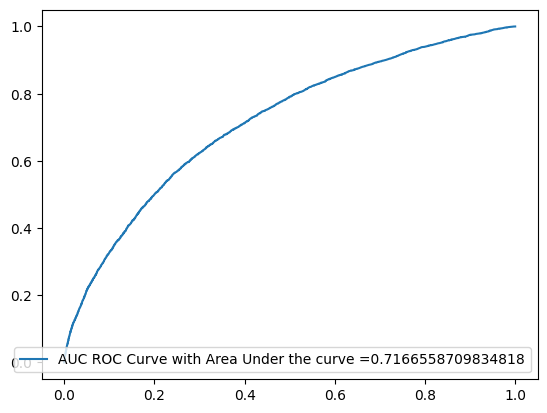

Logistic: f1=0.000 auc=0.202


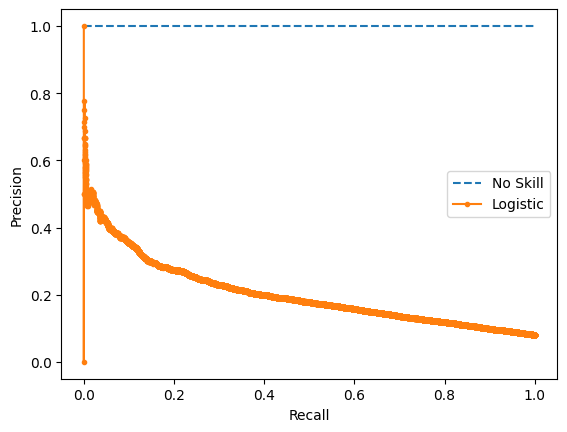

+------------------+---------------------+---------------------+
| Confusion Matrix | Positive prediction | Negative prediction |
+------------------+---------------------+---------------------+
|  Positive class  |  True positive (TP) | False negative (FN) |
|  Negative class  | False positive (FP) |  True negative (TN) |
+------------------+---------------------+---------------------+
+------------------+---------------------+---------------------+
| Confusion Matrix | Positive prediction | Negative prediction |
+------------------+---------------------+---------------------+
|  Positive class  |          0          |         4884        |
|  Negative class  |          1          |        56618        |
+------------------+---------------------+---------------------+
ROC AUC:  0.4999911690421943
Accuracy =  0.9205729801798286
Precision =  0.0
Recall =  0.0
F1 Score =  0.0
Fbeta Score =  (0.49, 0.92, 0.9)
                model     tn  fp    fn  tp  FP+10*FN  accuracy   ROC_AUC  \
0  R

In [228]:
run_name = "RFC_newFEATURE_002"
RFC_model_002, best_RFC_params, time_RFC = RFC_model(new_X_train_002, Y_train)
RFC_metrics, best_metrics_RFC            = generate_model_report(RFC_model_002, run_name, new_X_test_002, Y_test, time_RFC)
run_MLflow(experiment_name, run_name, RFC_metrics, 
           best_RFC_params, RFC_model_002, new_X_train_002)

START time Sat Mar  2 16:58:13 2024
start RandomizedSearchCV 
Fitting 5 folds for each of 6 candidates, totalling 30 fits


The total space of parameters 6 is smaller than n_iter=100. Running 6 iterations. For exhaustive searches, use GridSearchCV.


START time Sat Mar  2 16:58:13 2024
END time Sat Mar  2 17:04:55 2024  duration 6.689607028166453 min

---------------------------------
start generate_model_report


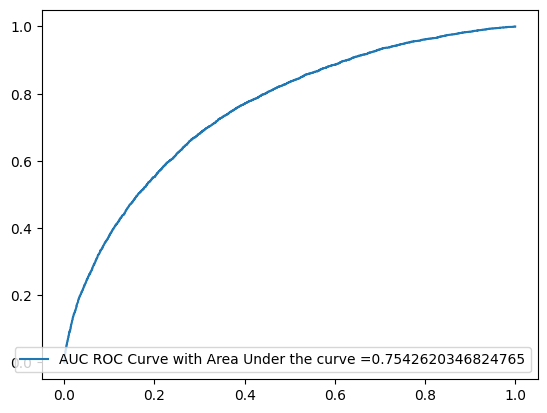

Logistic: f1=0.041 auc=0.236


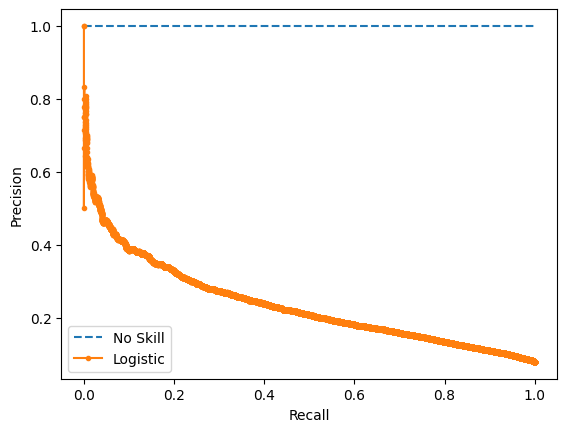

+------------------+---------------------+---------------------+
| Confusion Matrix | Positive prediction | Negative prediction |
+------------------+---------------------+---------------------+
|  Positive class  |  True positive (TP) | False negative (FN) |
|  Negative class  | False positive (FP) |  True negative (TN) |
+------------------+---------------------+---------------------+
+------------------+---------------------+---------------------+
| Confusion Matrix | Positive prediction | Negative prediction |
+------------------+---------------------+---------------------+
|  Positive class  |         104         |         4780        |
|  Negative class  |          88         |        56531        |
+------------------+---------------------+---------------------+
ROC AUC:  0.5098698863601105
Accuracy =  0.9208493894606767
Precision =  0.5416666666666666
Recall =  0.021294021294021293
F1 Score =  0.04097714736012609
Fbeta Score =  (0.5, 0.92, 0.91)
         model     tn  fp    fn 

In [231]:
run_name = "XGB_Shap002"
XGB_model_002, XGB_002_params, time_XGB_002 = train_XGBoost_model(new_X_train_002, Y_train)
XGB_002_metrics, best_metrics_XGB           = generate_model_report(XGB_model_002, run_name, new_X_test_002, Y_test, time_XGB_002)
run_MLflow(experiment_name, run_name, XGB_002_metrics, 
           XGB_002_params, XGB_model_002, new_X_train_002)


START time Sat Mar  2 23:53:42 2024
Fitting 5 folds for each of 1 candidates, totalling 5 fits


The total space of parameters 1 is smaller than n_iter=50. Running 1 iterations. For exhaustive searches, use GridSearchCV.


[CV 1/5] END boosting_type=gbdt, class_weight=balanced, learning_rate=0.05, metric=binary_logloss, n_estimators=10000, num_leaves=31, objective=binary, reg_alpha=0.1, reg_lambda=0.1, subsample=0.8;, score=nan total time=   1.5s


/Users/markobriesemann/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/markobriesemann/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[CV 4/5] END boosting_type=gbdt, class_weight=balanced, learning_rate=0.05, metric=binary_logloss, n_estimators=10000, num_leaves=31, objective=binary, reg_alpha=0.1, reg_lambda=0.1, subsample=0.8;, score=nan total time=   1.4s


/Users/markobriesemann/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/markobriesemann/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[CV 3/5] END boosting_type=gbdt, class_weight=balanced, learning_rate=0.05, metric=binary_logloss, n_estimators=10000, num_leaves=31, objective=binary, reg_alpha=0.1, reg_lambda=0.1, subsample=0.8;, score=nan total time=   1.5s


/Users/markobriesemann/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/markobriesemann/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[CV 2/5] END boosting_type=gbdt, class_weight=balanced, learning_rate=0.05, metric=binary_logloss, n_estimators=10000, num_leaves=31, objective=binary, reg_alpha=0.1, reg_lambda=0.1, subsample=0.8;, score=nan total time=   1.5s


/Users/markobriesemann/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/markobriesemann/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[CV 5/5] END boosting_type=gbdt, class_weight=balanced, learning_rate=0.05, metric=binary_logloss, n_estimators=10000, num_leaves=31, objective=binary, reg_alpha=0.1, reg_lambda=0.1, subsample=0.8;, score=nan total time=   1.5s


/Users/markobriesemann/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/markobriesemann/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Number of positive: 19941, number of negative: 226067
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.043252 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10313
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 96
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
START time Sat Mar  2 23:53:42 2024
END time Sun Mar  3 00:02:10 2024  duration 8.468631815910339 min

---------------------------------
start generate_model_report


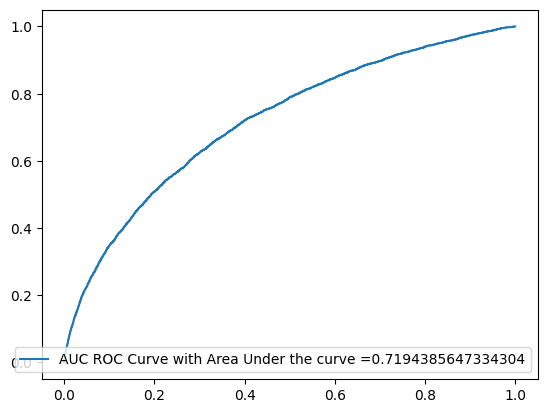

Logistic: f1=0.268 auc=0.210


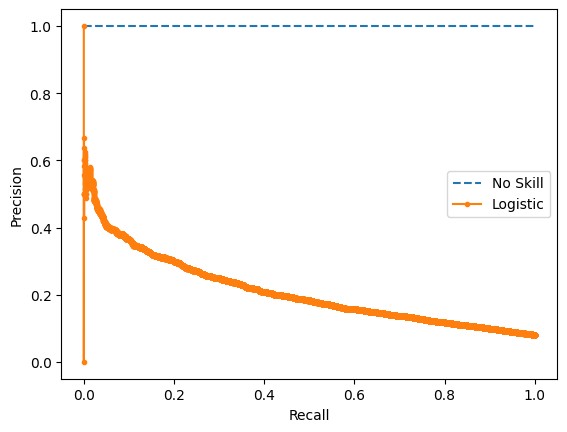

+------------------+---------------------+---------------------+
| Confusion Matrix | Positive prediction | Negative prediction |
+------------------+---------------------+---------------------+
|  Positive class  |  True positive (TP) | False negative (FN) |
|  Negative class  | False positive (FP) |  True negative (TN) |
+------------------+---------------------+---------------------+
+------------------+---------------------+---------------------+
| Confusion Matrix | Positive prediction | Negative prediction |
+------------------+---------------------+---------------------+
|  Positive class  |         1410        |         3474        |
|  Negative class  |         4219        |        52400        |
+------------------+---------------------+---------------------+
ROC AUC:  0.6070910833667152
Accuracy =  0.874916670731509
Precision =  0.2504885414816131
Recall =  0.28869778869778867
F1 Score =  0.2682393227432703
Fbeta Score =  (0.6, 0.87, 0.88)
          model     tn    fp    fn 

In [251]:
run_name = "LGBM_Shap002"
LGBM_model_002, LGBM_002_params, time_LGBM_002 = train_LightGBM_model(new_X_train_002, Y_train)
LGBM_002_metrics, best_metrics_LGBM           = generate_model_report(LGBM_model_002, run_name, new_X_test_002, Y_test, time_LGBM_002)
run_MLflow(experiment_name, run_name, LGBM_002_metrics, 
           LGBM_002_params, LGBM_model_002, new_X_train_002)

In [245]:
new_X_train_002.head()

,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,...,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Military,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_XNA,FONDKAPREMONT_MODE_reg oper account,"WALLSMATERIAL_MODE_Stone, brick",EMERGENCYSTATE_MODE_No,DAYS_EMPLOYED_ANOM
0,0.0,0.0,1.0,0.0,202500.0,406597.5,24700.5,351000.0,0.018801,9461.0,...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
1,0.0,0.0,0.0,0.0,270000.0,1293502.5,35698.5,1129500.0,0.003541,16765.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,1.0,1.0,1.0,0.0,67500.0,135000.0,6750.0,135000.0,0.010032,19046.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,135000.0,312682.5,29686.5,297000.0,0.008019,19005.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,121500.0,513000.0,21865.5,513000.0,0.028663,19932.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Run with Shap filtered and scaled data to assess impact on metrics

In [259]:
X_train_002_scale, X_test_002_scale = scale_data(new_X_train_002, new_X_test_002)

In [261]:
run_name = "LGBM_Shap002_scaled"
LGBM_model_002_scale, LGBM_002_scale_params, time_LGBM_002 = train_LightGBM_model(X_train_002_scale, Y_train)
LGBM_002_scale_metrics, best_metrics_LGBM_scale           = generate_model_report(LGBM_model_002_scale, run_name, X_test_002__scale, Y_test, time_LGBM_002)
run_MLflow(experiment_name, run_name, LGBM_002__scale_metrics, 
           LGBM_002_scale_params, LGBM_model_002_scale, X_train_002_scale)

START time Mon Mar  4 10:37:28 2024
Fitting 5 folds for each of 1 candidates, totalling 5 fits


The total space of parameters 1 is smaller than n_iter=50. Running 1 iterations. For exhaustive searches, use GridSearchCV.
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Number of positive: 19941, number of negative: 226067
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034363 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10311
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 96
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
START time Mon Mar  4 10:37:28 2024
END time Mon Mar  4 10:45:34 2024  duration 8.090808200836182 min


NameError: name 'X_test_002__scale' is not defined

[LightGBM] [Info] Number of positive: 15953, number of negative: 180854
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.107711 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10236
[LightGBM] [Info] Number of data points in the train set: 196807, number of used features: 96
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[CV 5/5] END boosting_type=gbdt, class_weight=balanced, learning_rate=0.05, metric=binary_logloss, n_estimators=10000, num_leaves=31, objective=binary, reg_alpha=0.1, reg_lambda=0.1, subsample=0.8;, score=0.888 total time= 5.5min


/Users/markobriesemann/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/markobriesemann/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 15953, number of negative: 180854
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049505 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10305
[LightGBM] [Info] Number of data points in the train set: 196807, number of used features: 96
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[CV 4/5] END boosting_type=gbdt, class_weight=balanced, learning_rate=0.05, metric=binary_logloss, n_estimators=10000, num_leaves=31, objective=binary, reg_alpha=0.1, reg_lambda=0.1, subsample=0.8;, score=0.885 total time= 5.5min


/Users/markobriesemann/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/markobriesemann/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


## Test MLflow on Fastapi model serving

In [ ]:
!curl http://127.0.0.1:8000/predict -H 'Content-Type: application/json' -d '{"inputs": [[0, 0, 1, 1, 63000.0, 310500.0, 15232.5, 310500.0, 0.026392, 16263, -214.0, -8930.0, -573, 0.0, 1, 1, 0, 1, 1, 0, 2.0, 2, 2, 11, 0, 0, 0, 0, 1, 1, 0.0, 0.0765011930557638, 0.0005272652387098, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, true, false, false, false, false, false, false, false, true, false, false, false, false, false, false, true, false, false, false, false, true, false, false, false, true, false, false, true, false, false, false, false, false, false, false, false, false, false, true, false, false, false, false, false, false, false, false, true, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false]]}'
  

In [ ]:
!curl http://127.0.0.1:8000/predict -H 'Content-Type: application/json' -d '{"data_point": [[0, 0, 1, 1, 63000.0, 310500.0, 15232.5, 310500.0, 0.026392, 16263, -214.0, -8930.0, -573, 0.0, 1, 1, 0, 1, 1, 0, 2.0, 2, 2, 11, 0, 0, 0, 0, 1, 1, 0.0, 0.0765011930557638, 0.0005272652387098, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, true, false, false, false, false, false, false, false, true, false, false, false, false, false, false, true, false, false, false, false, true, false, false, false, true, false, false, true, false, false, false, false, false, false, false, false, false, false, true, false, false, false, false, false, false, false, false, true, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false, false]]}'


In [141]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 246008 entries, 0 to 246007
Columns: 239 entries, 0 to 238
dtypes: bool(132), float64(66), int64(41)
memory usage: 231.8 MB


**Selection of a data point for testing**

In [ ]:
test = X_train.copy()
test["ID"] = ids_test
test.set_index("ID", inplace=True)
ids_test.iloc[5]
#test.loc[100008].values.tolist()
data_for_request = test.loc[100030].values.tolist()

In [ ]:
#data_for_request

In [ ]:
import requests

# initialised with: mlflow models serve -m model_LGBM02/ --port 8092
#http://127.0.0.1:8092

host = '127.0.0.1'
port = '8000'

# endpoint
url = f'http://{host}:{port}/predict'
print("URI : ", url)
headers = {
    'Content-Type': 'application/json',
}

headers = {'Content-Type': 'application/json'}

# Send the POST request with the data
response = requests.post(url, json={"data_point": data_for_request})

print(f'Predictions: {response.text}')

**TEST with empty data set**

In [ ]:
# Send the POST request with the data
response = requests.post(url, json={"data_point":[]})

print(f'Predictions: {response.text}')

**TEST on hosting environment**

In [ ]:
url = 'https://fastapi-cd-webapp.azurewebsites.net/predict'
# Send the POST request with the data
response = requests.post(url, json={"data_point": data_for_request})

print(f'Predictions: {response.text}')